In [1]:
from notebook_helper import *
from helpers import la, space, viz
notebook_setup()
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# Deprivation and density clusters

As a point of comparison, this notebook calculates distances and clusters for deprivation. 

A single deprivation score is calculated for each area. Have some notes about splitting deprivation into multiple axis to account for different patterns of deprivation rather than an 'average' over an area, but not implimented in this approach. 

This uses the [mySociety UK wide deprivation scores](https://raw.githubusercontent.com/mysociety/composite_uk_imd) for a consistent comparison. 

In [49]:
# This follows methodology in https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/833947/IoD2019_Research_Report.pdf p. 69

# update the lookup to current replacement
lsoa_la = pd.read_csv(Path("data", "imd", "lsoa_datazone_la.csv"))
lsoa_la = lsoa_la.la.get_council_info(["replaced_by"],include_historical=True)
lsoa_la["local-authority-code"] = np.where(lsoa_la["replaced_by"].isna(), lsoa_la["local-authority-code"], lsoa_la["replaced_by"])
lsoa_la = lsoa_la.drop(columns=["replaced_by"]).set_index("lsoa")

# merge lsoa to la lookup column
df = pd.read_csv(Path("data","imd", "UK_IMD_E.csv")).set_index("lsoa")
df = df.join(lsoa_la)

# merge lsoa population in
pop = pd.read_csv(Path("data", "imd", "2019_population.csv"), thousands=",").set_index("lsoa")
df = df.join(pop)

# create a population adjusted score
df["pop_score"] = df["UK_IMD_E_score"] * df["pop"]

# pivot up to the local authority level
pt = df.pivot_table(["pop_score","pop"], index="local-authority-code", aggfunc="sum")

# combine these for the higher level authorities
pt = pt.reset_index()
higher_df = pt.la.to_higher(aggfunc="sum")
pt = pd.concat([pt, higher_df])

# calculate a new score, dividing the summed score by the summed population
pt["la_deprivation_score"] = pt["pop_score"] / pt["pop"]
pt = pt.sort_values("la_deprivation_score", ascending=False)
pt = pt.drop(columns=["pop", "pop_score"])
df = pt
df.head()

,local-authority-code,la_deprivation_score
33,BPL,45.487057
167,KWL,43.165483
176,LIV,42.536504
163,KHL,40.631076
184,MDB,40.380964


In [68]:
# add population and area info 
df = df.la.get_council_info(["pop_2020", "area"])
df["density"] = df["pop_2020"] / df["area"]

In [74]:
df.to_csv("test2.csv")

# Distance analysis

Low agreement between deprivation/density distance and both geographic distance and pollution distance, so not measuring the same thing from different angles.


### Comparison with geographic distance

In [83]:
dep_distance = df.space.self_distance("local-authority-code", ["la_deprivation_score", "density"], normalize=True)

dep_distance.to_csv(Path("data","outputs","deprivation_distance_v1.csv"), index=False)

real_distance = pd.read_csv(Path("data", "outputs", "geographic_distance.csv" ))

jd = space.join_distance({"deprivation_distance": dep_distance,
                         "real_distance": real_distance})
jd.joint_space.agreement()

,top_k,agreement
0,1,0.02
1,2,0.03
2,3,0.05
3,5,0.06
4,10,0.08
5,25,0.12


### Comparison with pollution distance

In [84]:
dep_distance = df.space.self_distance("local-authority-code", ["la_deprivation_score", "density"], normalize=True)

pol_distance = pd.read_csv(Path("data", "outputs", "council_clusters_v1_distance.csv" ))

jd = space.join_distance({"deprivation_distance": dep_distance,
                         "pop_distance": pol_distance})
jd.joint_space.agreement()

,top_k,agreement
0,1,0.02
1,2,0.03
2,3,0.03
3,5,0.06
4,10,0.08
5,25,0.16


# Deprivation clusters analysis

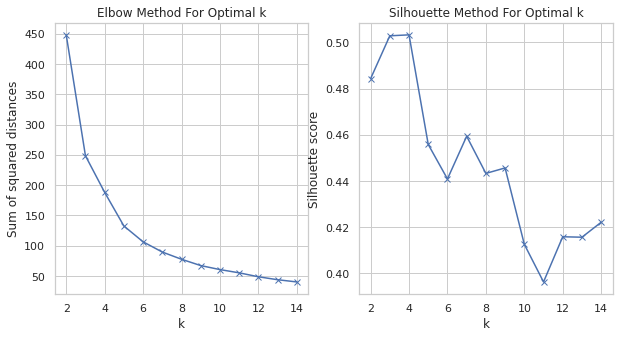

In [75]:
cluster = space.Cluster(df, "local-authority-code", cols=["la_deprivation_score", "density"], label_cols=[], normalize=True)
cluster.find_k(2,15)

This suggests highest cohesion for 4 clusters, which as the graph shows groups fairly nicely into a split into high and low deprivation, and then two other clusters that are especially dense. 

In [76]:
# 4 clusters looks good
cluster.set_k(4)
nice_name_lookup = la.get_la_df().set_index("local-authority-code")["official-name"].to_dict()
stats = cluster.stats(label_lookup=nice_name_lookup)
stats

,count,%,random members
labels,,,
1,110,27.8,"[Sunderland City Council, South Tyneside Counc..."
2,222,56.2,"[Powys County Council, Mid Devon District Coun..."
3,50,12.7,"[Brighton and Hove City Council, London Boroug..."
4,13,3.3,"[London Borough of Hackney, London Borough of ..."


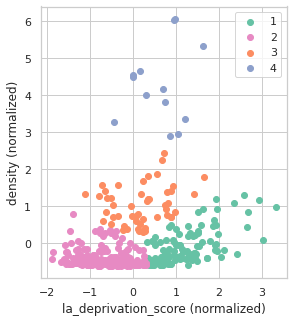

In [77]:
cluster.plot()

In [78]:
cluster.raincloud_tool()

interactive(children=(Dropdown(description='variable', options=('la_deprivation_score', 'density'), value='la_…

In [79]:
cluster.assign_name(n=1, name="Mainstream A", desc="Above average deprivation")
cluster.assign_name(n=2, name="Mainstream B", desc="Below average deprivation")
cluster.assign_name(n=3, name="Outlier A", desc="Above average deprivation and density")
cluster.assign_name(n=4, name="Outlier B", desc="Very high deprivation, above average deprivation.")
cluster.stats(label_lookup=nice_name_lookup)    

,count,%,random members
labels,,,
1: Mainstream A,110,27.8,"[Pembrokeshire County Council, Bolsover Distri..."
2: Mainstream B,222,56.2,"[Malvern Hills District Council, Winchester Ci..."
3: Outlier A,50,12.7,"[Stevenage Borough Council, Greater London Aut..."
4: Outlier B,13,3.3,"[London Borough of Lewisham, London Borough of..."


In [81]:
out_df = cluster.df_with_labels()
out_df.to_csv(Path("data", "outputs", "deprivation_cluster_v1.csv"), index=False)